这个 notebook 文件会示例如何使用 pytorch_lightning_quick_start_utils 完成 ResNet 在 MNIST 上的训练。

## 导入包

In [ ]:
import torch
import torch.nn as nn
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import lightning as L

## 训练前的初始化

In [ ]:
from pl_utils import init_before_training

init_before_training(empty_cache=False)  # 不清理缓存，设置随机种子，设置浮点数精度

## 配置

In [3]:
from pl_utils import LearningRateConfig, TrainingConfig

learning_rate_config = LearningRateConfig(
    lr_warmup_steps=10,
    lr_initial=1e-5,
    lr_max=1e-4,
    lr_end=1e-5,
)

training_config = TrainingConfig(
    optimizer='adamw',
    optimizer_args={
        'betas': (0.9, 0.95),
        'weight_decay': 1e-3,
        "fused": True,
    },
)

## 数据集定义

In [4]:
from pl_utils import get_train_val_dataloader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader, val_loader = get_train_val_dataloader(
    [train_dataset, test_dataset],
    batch_size=64,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
    persistent_workers=True,
    train_shuffle=True,
)

## 模型定义

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.downsample(x)
        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.fc = nn.Linear(8192 * 1 * 1, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## Lightning

In [6]:
from pl_utils import BaseModule


class ResNetForMNIST(BaseModule):
    def __init__(
        self,
        model,
        lr_config: LearningRateConfig,
        training_config: TrainingConfig,
    ):
        super(ResNetForMNIST, self).__init__(model, lr_config, training_config)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = self.criterion(output, target)
        grad_norm = nn.utils.clip_grad_norm_(self.model.parameters(), 2.0)
        self.log("train/loss", loss, on_step=True, on_epoch=True)
        self.log("train/grad_norm", grad_norm, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = self.criterion(output, target)
        self.log("val/loss", loss, on_step=False, on_epoch=True)

        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / target.size(0)
        self.log("val/accuracy", accuracy, on_step=False, on_epoch=True)

        return loss

## 实例化模型

In [7]:
model = ResNet(ResidualBlock, [2, 2, 2, 2])
pl_model = ResNetForMNIST(model, learning_rate_config, training_config)

model.compile(
    fullgraph=False,
    dynamic=False,
    options={
        "shape_padding": True,
        "max_autotune": True,
    },
)

## 准备

In [ ]:
import lightning.pytorch as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from pl_utils.lightning import format_next_version_name, get_specified_version_name

name = "训练测试"  # 当前版本名称。会作为 log_dir 的一部分

checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    auto_insert_metric_name=True,
    monitor="val/loss",
    mode="min",
    every_n_epochs=10,
    save_weights_only=False,
    save_last="link",
)

trainer_config = {
    "accelerator": "gpu",
    "max_epochs": 300,
    "precision": "bf16-mixed",
    # "accumulate_grad_batches": 4,
    "log_every_n_steps": 1,
    "default_root_dir": "./",
    "callbacks": [checkpoint_callback],
    "num_sanity_val_steps": 0,
}

## 开始训练

In [ ]:
logger = TensorBoardLogger(save_dir="./", version=format_next_version_name(name))

trainer = L.Trainer(
    logger=logger,
    # fast_dev_run=True,
    **trainer_config,
)

trainer.fit(pl_model, train_loader, val_loader)

在 TensorBoard 上看训练结果

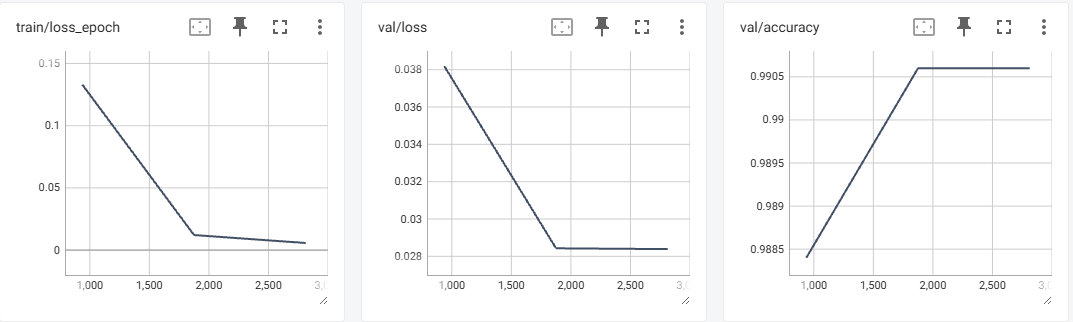

## 从检查点继续训练

In [ ]:
current_version = get_specified_version_name()  # 不传入参数时，获取最新版本的名称
logger = TensorBoardLogger(save_dir="./", version=current_version)

trainer = L.Trainer(
    logger=logger,
    **trainer_config,
)

trainer.fit(
    pl_model,
    train_loader,
    val_loader,
    # ckpt_path=f"./lightning_logs/{current_version}/checkpoints/epoch=229-step=9890.ckpt",
    ckpt_path="last",
)